# Feature Generation

In [1]:
pip install plotly

  Using cached plotly-6.0.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached narwhals-1.30.0-py3-none-any.whl.metadata (11 kB)
Using cached plotly-6.0.0-py3-none-any.whl (14.8 MB)
Using cached narwhals-1.30.0-py3-none-any.whl (313 kB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
import json
import zipfile
from scipy.sparse import load_npz
import random
from tqdm import tqdm
import plotly.express as px
import pandas as pd

In [3]:
url_domains = pd.read_csv('../02_data/url_domains_compressed.csv.gz', compression='gzip')

In [4]:
# Load datasets
chats = pd.read_parquet('../02_data/chats.parquet')

# chat_index = np.load('../02_data/chat_index.npy')
# url_domains = pd.read_csv('../02_data/url_domains.csv')
url_domains.info()
domain_pc1 = pd.read_csv('../02_data/domain_pc1.csv')
url_data = pd.read_parquet('../02_data/url.data.parquet')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18141615 entries, 0 to 18141614
Data columns (total 19 columns):
 #   Column               Dtype  
---  ------               -----  
 0   index                int64  
 1   url                  object 
 2   domain               object 
 3   messages             int64  
 4   chats                int64  
 5   avalanches           int64  
 6   mean_avalanche_size  float64
 7   top_avalanche_size   int64  
 8   virality             float64
 9   top_shares_1h        int64  
 10  top_shares_6h        int64  
 11  top_shares_1d        int64  
 12  top_shares_3d        int64  
 13  top_shares_14d       int64  
 14  first_share_date     object 
 15  final_share_date     object 
 16  pc1                  float64
 17  rank                 float64
 18  year                 int64  
dtypes: float64(4), int64(11), object(4)
memory usage: 2.6+ GB


In [5]:
chat_url_shares = load_npz('../02_data/chat_url_shares.npz')

## Check Embeddings

In [6]:
article_embeddings = pd.read_parquet("../02_data/article_embeddings.parquet")
article_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336561 entries, 0 to 336560
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   index      336561 non-null  int64 
 1   url        336561 non-null  object
 2   article    336561 non-null  object
 3   embedding  336561 non-null  object
dtypes: int64(1), object(3)
memory usage: 10.3+ MB


In [7]:
# Merge article_embeddings with url_domains to get domain
article_embeddings = pd.merge(
    article_embeddings,
    url_domains[['index', 'domain', 'virality', 'avalanches', 'messages', 'chats', 'pc1', 'year']],
    on='index',
    how='inner'
).rename(columns={'index': 'url_index', 'embedding':'article_embedding'})

In [8]:
article_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336561 entries, 0 to 336560
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   url_index          336561 non-null  int64  
 1   url                336561 non-null  object 
 2   article            336561 non-null  object 
 3   article_embedding  336561 non-null  object 
 4   domain             336561 non-null  object 
 5   virality           336561 non-null  float64
 6   avalanches         336561 non-null  int64  
 7   messages           336561 non-null  int64  
 8   chats              336561 non-null  int64  
 9   pc1                336561 non-null  float64
 10  year               336561 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 28.2+ MB


In [9]:
embeddings = np.vstack(article_embeddings['article_embedding'])
print("Embeddings shape:", embeddings.shape)

Embeddings shape: (336561, 384)


In [10]:
filtered_df = article_embeddings.loc[article_embeddings['url_index'] < 5000]
filtered_embeddings = np.vstack(filtered_df['article_embedding'])

In [11]:
# Select 5 random domains
random_domains = article_embeddings["domain"].dropna().unique()  # Get unique domains
random_sampled_domains = pd.Series(random_domains).sample(5, random_state=42).tolist()  # Select 5 randomly

# Filter the dataset to include only the selected domains
filtered_df = article_embeddings[article_embeddings["domain"].isin(random_sampled_domains)]

# Stack the embeddings
filtered_embeddings = np.vstack(filtered_df['article_embedding'])

In [12]:
pip install umap-learn

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Note: you may need to restart the kernel to use updated packages.


UMAP to reduce the dimensionality of the embeddings to 2D or 3D for visualization, different colors for the scatter plots in order to identify clusters

In [13]:
from umap.umap_ import UMAP
import matplotlib.pyplot as plt

In [14]:
embeddings = np.vstack(filtered_df['article_embedding'])

In [15]:
# Assuming `embeddings` is a matrix of shape (n_samples, embedding_dim)
umap_model = UMAP(n_components=2, random_state=42)
low_dim_embeddings = umap_model.fit_transform(filtered_embeddings)


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


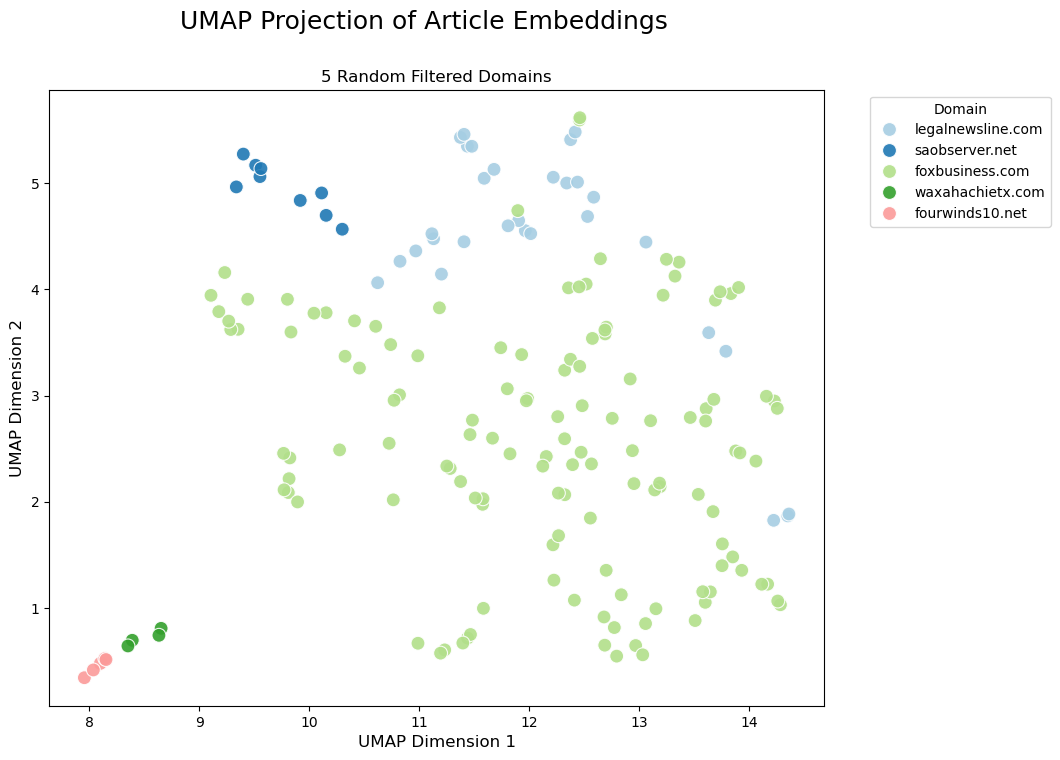

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=low_dim_embeddings[:, 0],
    y=low_dim_embeddings[:, 1],
    hue=filtered_df['domain'],  # Replace with the metadata, e.g., domains, labels, etc.
    palette='Paired',
    s=100,
    alpha=0.9
)
plt.suptitle("UMAP Projection of Article Embeddings", fontsize=18)
plt.title("5 Random Filtered Domains", fontsize=12)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)

# Hide legend
# plt.legend([], [], frameon=False)
plt.legend(title="Domain", bbox_to_anchor=(1.05, 1), loc="upper left") #, fontsize="big"

# Export the plot as an image file
plt.savefig("../03_plots/umap_projection.png", dpi=300, bbox_inches="tight")

# Show the plot (optional)
plt.show()


In [17]:
# Assuming `low_dim_embeddings` is a numpy array and `filtered_df['domain']` is your metadata
# Convert data to a DataFrame for Plotly
# plot_data = pd.DataFrame({
    "UMAP Dim 1": low_dim_embeddings[:, 0],
    "UMAP Dim 2": low_dim_embeddings[:, 1],
    "Domain": article_embeddings['domain']
})

# Create an interactive scatter plot
# fig = px.scatter(
    plot_data,
    x="UMAP Dim 1",
    y="UMAP Dim 2",
    color="Domain",  # Replace with the column you want to use for coloring
    title="Zoomable UMAP Projection of Article Embeddings",
    opacity=0.7,
)

# Customize the plot layout
# fig.update_layout(
    title_font_size=20,
    xaxis_title="UMAP Dimension 1",
    yaxis_title="UMAP Dimension 2",
    legend_title="Domain",  # Optional: customize legend title
    showlegend=False,       # Hide legend
)

# Show the plot
# fig.show()

# Save the plot as an HTML file for sharing
# fig.write_html("../03_plots/zoom_umap_projection.html")


IndentationError: unexpected indent (371432704.py, line 4)

In [18]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 178 entries, 6336 to 333552
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url_index          178 non-null    int64  
 1   url                178 non-null    object 
 2   article            178 non-null    object 
 3   article_embedding  178 non-null    object 
 4   domain             178 non-null    object 
 5   virality           178 non-null    float64
 6   avalanches         178 non-null    int64  
 7   messages           178 non-null    int64  
 8   chats              178 non-null    int64  
 9   pc1                178 non-null    float64
 10  year               178 non-null    int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 16.7+ KB


In [19]:
from sklearn.metrics import silhouette_score, normalized_mutual_info_score

umap_model = UMAP(n_components=2, random_state=42)
low_dim_embeddings = umap_model.fit_transform(filtered_embeddings)

# Example for silhouette score
sil_score = silhouette_score(low_dim_embeddings, filtered_df['domain'])
print("Silhouette Score:", sil_score)

Silhouette Score: 0.1435738


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [20]:
article_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336561 entries, 0 to 336560
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   url_index          336561 non-null  int64  
 1   url                336561 non-null  object 
 2   article            336561 non-null  object 
 3   article_embedding  336561 non-null  object 
 4   domain             336561 non-null  object 
 5   virality           336561 non-null  float64
 6   avalanches         336561 non-null  int64  
 7   messages           336561 non-null  int64  
 8   chats              336561 non-null  int64  
 9   pc1                336561 non-null  float64
 10  year               336561 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 28.2+ MB


## Filter English 

In [21]:
pip install langdetect

  Using cached langdetect-1.0.9-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [22]:
# from langdetect import detect

In [23]:
tqdm.pandas(desc="Processing articles")

# Function to check if text is in English
def is_english(text, char_limit=25):
    try:
        truncated_text = text[:char_limit]  # Shorten the text
        return detect(truncated_text) == "en"
    except:
        return False

# Apply the function to the column
# article_embeddings["is_english"] = article_embeddings["article"].progress_apply(is_english)
# Output the results
# print(article_embeddings)

In [24]:
# Group by domain and count English articles
# grouped = article_embeddings.groupby("domain")["is_english"].sum().reset_index()
# grouped.columns = ["domain", "english_article_count"]

# Count domains with no English articles
# domains_no_english = grouped[grouped["english_article_count"] == 0].shape[0]

# Print results
# print("Articles grouped by domain with English counts:")
# print(grouped)
# print(f"\nNumber of domains with no English articles: {domains_no_english}")

In [25]:
# article_embeddings = article_embeddings[article_embeddings["is_english"] == True]

In [26]:
domains = article_embeddings['domain'].unique()
len(domains)

5942

## Aggregate Data by Domain

In [27]:
# Filter chat_url_shares to keep only URLs present in article_embeddings
valid_url_indices = article_embeddings['url_index'].values
filtered_chat_url_shares = chat_url_shares.tocsr()[:, valid_url_indices]

In [28]:
valid_url_indices

array([     102,      949,      960, ...,  3154828, 36333389,  3154829])

In [29]:
filtered_chat_url_shares

<65338x336561 sparse matrix of type '<class 'numpy.int64'>'
	with 2839421 stored elements in Compressed Sparse Row format>

In [30]:
# Threshold for classification
threshold = 0.5

In [31]:
# Define fake/non-fake labels based on pc1 threshold
article_embeddings['label'] = (article_embeddings['pc1'] > threshold).astype(int)

In [32]:
article_embeddings.head()

,url_index,url,article,article_embedding,domain,virality,avalanches,messages,chats,pc1,year,label
0,102,https://doctors4covidethics.org/timeline-of-th...,Timeline: Prof. Sucharit Bhakdi Case – Doctors...,"[-0.099953696, 0.24610601, -0.09983195, -0.098...",doctors4covidethics.org,0.154919,70,100,52,0.351909,2023,0
1,949,https://doctors4covidethics.org/session-iii-ge...,"Symposium 5, Session III: Getting Away From th...","[0.088956945, 0.04218834, -0.10458192, 0.06942...",doctors4covidethics.org,0.294392,22,30,25,0.351909,2023,0
2,960,https://live.childrenshealthdefense.org/chd-tv...,Part 1: Here We Go Again On Steroids | Childre...,"[-0.14336067, 0.12084216, 0.058760908, -0.0902...",childrenshealthdefense.org,0.162540,108,186,132,0.176170,2023,0
3,669,https://www.thepulse.one/p/the-biggest-threat-...,CBDC's & Their Impact On Freedom - by Joe Mart...,"[-0.09803312, 0.07620642, -0.39123908, -0.0204...",thepulse.one,0.114767,82,88,51,0.305638,2023,0
4,90,https://www.dailymail.co.uk/health/article-121...,Prepare for a disease even deadlier than Covid...,"[0.049983677, 0.034944754, -0.03067252, -0.012...",dailymail.co.uk,0.236128,194,455,246,0.383861,2023,0


In [33]:
# Randomly select one article per domain
random_article_per_domain = article_embeddings.groupby('domain').apply(lambda x: x.sample(1)).reset_index(drop=True)

# adding an index
random_article_per_domain['domain_index'] = random_article_per_domain['domain'].factorize()[0]

# Aggregate based on the selected articles
aggregated_data = random_article_per_domain.groupby('domain').agg({
    'domain_index': 'first',
    'url_index': 'first',
    'article': 'first',
    'article_embedding': lambda x: np.mean([np.array(ast.literal_eval(e)) if isinstance(e, str) else e for e in x], axis=0),
    'virality': 'mean',
    'avalanches': 'mean',
    'messages': 'mean',
    'chats': 'mean',
    'year': 'mean',
    'domain_index': 'first',  # Since there's only one per domain
    'pc1': 'first',
    'label': 'first'  
}).reset_index()

aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   domain             5942 non-null   object 
 1   domain_index       5942 non-null   int64  
 2   url_index          5942 non-null   int64  
 3   article            5942 non-null   object 
 4   article_embedding  5942 non-null   object 
 5   virality           5942 non-null   float64
 6   avalanches         5942 non-null   float64
 7   messages           5942 non-null   float64
 8   chats              5942 non-null   float64
 9   year               5942 non-null   float64
 10  pc1                5942 non-null   float64
 11  label              5942 non-null   int64  
dtypes: float64(6), int64(3), object(3)
memory usage: 557.2+ KB


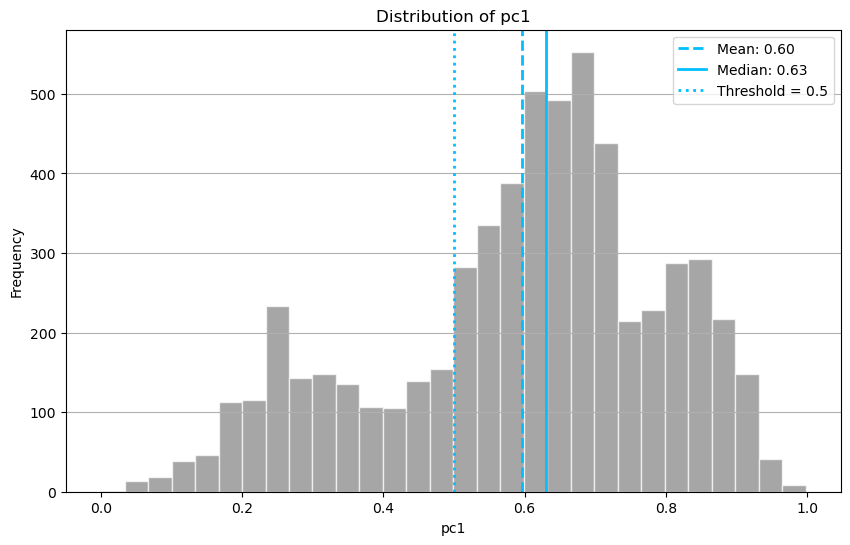

In [34]:
# Compute mean and median
mean_value = aggregated_data['pc1'].mean()
median_value = aggregated_data['pc1'].median()
threshold = 0.5  # Given threshold

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(aggregated_data['pc1'], color='grey', alpha=0.7, edgecolor='white', bins=30)  # Adjust bins if needed

# Add vertical lines for mean, median, and threshold
plt.axvline(mean_value, color='deepskyblue', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='deepskyblue', linestyle='-', linewidth=2, label=f'Median: {median_value:.2f}')
plt.axvline(threshold, color='deepskyblue', linestyle=':', linewidth=2, label='Threshold = 0.5')

# Customize plot
plt.title('Distribution of pc1')
plt.xlabel('pc1')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.legend()  # Show legend for the lines

# Save and show the plot
plt.savefig('../03_plots/hist_pc1.png')
plt.show()

In [35]:
aggregated_data

,domain,domain_index,url_index,article,article_embedding,virality,avalanches,messages,chats,year,pc1,label
0,100giornidaleoni.it,0,22631029,"""Vi spiego la DIFFERENZA tra RUSSI e ITALIANI""...","[-0.12423741, -0.062898025, 0.006034705, 0.034...",1.000000,1.0,1.0,1.0,2022.0,0.259866,0
1,100milefreepress.net,1,7395289,First Nations use drone-seeding trial project ...,"[0.08478753, -0.10553236, -0.045697704, -0.162...",0.707107,2.0,2.0,2.0,2022.0,0.599200,1
2,100percentfedup.com,2,1732928,BREAKING: Chinese Doctor Says COVID-19 Release...,"[-0.038340196, 0.06266163, 0.167824, -0.165880...",0.424918,16.0,36.0,21.0,2022.0,0.219380,0
3,1011now.com,3,39960469,"US vote counting unaffected by cyberattacks, o...","[0.06609012, 0.038709376, -0.23690498, -0.1402...",1.000000,1.0,1.0,1.0,2022.0,0.716641,1
4,10news.com,4,7063760,Cal/OSHA: Fully vaccinated workers can shed ma...,"[0.2534634, 0.01553471, -0.044362582, 0.078020...",0.707107,2.0,2.0,2.0,2021.0,0.705943,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5937,zmescience.com,5937,4316279,First SciFi novel ever: A 2nd century AD book ...,"[-0.09211351, -0.15267372, -0.056884415, 0.050...",0.395285,7.0,8.0,4.0,2022.0,0.891073,1
5938,zombie.news,5938,45161637,CLAIM: Covid vaccines installed Marburg “paylo...,"[0.010096034, 0.030971166, -0.1290194, -0.0342...",1.000000,1.0,1.0,1.0,2023.0,0.243898,0
5939,zonazealots.com,5939,24808849,Andre Iguodala and Aaron Gordon investors in N...,"[0.045163967, -0.1131694, -0.3407165, -0.14510...",0.707107,2.0,4.0,1.0,2021.0,0.648646,1
5940,zuerst.de,5940,1549284,Doha straft Habeck Lügen: „Er gibt keine Energ...,"[-0.2195917, 0.43217063, -0.09191446, 0.255260...",1.000000,1.0,1.0,1.0,2023.0,0.675067,1


## Train Test Split

In [43]:
# Train-test split based on nodes (domains)
unique_domains = aggregated_data['domain'].unique()
train_domains, test_domains = train_test_split(unique_domains, test_size=0.2, random_state=42)

# Split data into train and test sets
train_data = aggregated_data[aggregated_data['domain'].isin(train_domains)]
test_data = aggregated_data[aggregated_data['domain'].isin(test_domains)]

node_features = aggregated_data[['domain_index', 'domain', 'article_embedding', 'virality', 'avalanches', 'messages', 'chats', 'year', 'pc1', 'label']].copy()

node_features['domain_index'] = node_features['domain_index'].astype(int)
node_features['year'] = node_features['year'].astype(int)
node_features['virality'] = node_features['virality'].round(2)

## Filter Chat URL matrix

In [44]:
# Mapping
unique_domains = train_data['domain'].dropna().unique()
url_to_domain = article_embeddings.set_index('url')['domain']
domain_to_index_map = train_data.set_index('domain')['domain_index']
#train_data['domain_index'] = article_embeddings['domain'].map(domain_to_index_map)
article_url_map = article_embeddings.set_index('url_index')['url']

In [45]:
article_url_map

url_index
102         https://doctors4covidethics.org/timeline-of-th...
949         https://doctors4covidethics.org/session-iii-ge...
960         https://live.childrenshealthdefense.org/chd-tv...
669         https://www.thepulse.one/p/the-biggest-threat-...
90          https://www.dailymail.co.uk/health/article-121...
                                  ...                        
685433      https://www.thebeaverton.com/2023/05/danielle-...
685459      https://unherd.com/thepost/dominic-cummings-th...
3154828         http://www.liveleak.com/view?i=cb0_1447249820
36333389    https://www.factinate.com/people/46-facts-abou...
3154829         http://www.liveleak.com/view?i=aec_1508296335
Name: url, Length: 336561, dtype: object

In [46]:
train_domains_set = set(train_domains)

In [ ]:
# Create edge list from filtered_chat_url_shares with domain indices
rows, cols = chat_url_shares.tocsr().nonzero()
edges = []

for row, col in tqdm(zip(rows, cols), total=len(rows), desc="Processing chat-url pairs"):
    url = article_url_map.get(col, None)  # Get URL safely
    if url is not None:
        domain = url_to_domain.get(url, None)  # Map URL to domain
        if isinstance(domain, pd.Series):
            domain = domain.iloc[0]
        if domain in train_domains_set:  # Only include training domains
            domain_index = domain_to_index_map.get(domain)  # Get index
            if domain_index is not None:
                edges.append((row, domain_index))  # Add valid edge

# Create the filtered edge list DataFrame
train_edge_list = pd.DataFrame(edges, columns=['chat_id', 'domain_index'])

Processing chat-url pairs:  21%|██        | 18802990/88524359 [1:13:39<2:02:54, 9454.00it/s] 

In [ ]:
# Ensure proper integer type
train_edge_list['chat_id'] = train_edge_list['chat_id'].astype(int)
train_edge_list['domain_index'] = train_edge_list['domain_index'].astype(int)

# Print statistics for verification
print(f"Train Edge List Shape: {train_edge_list.shape}")
print(f"Max domain index: {train_edge_list['domain_index'].max()}")
print(f"Min domain index: {train_edge_list['domain_index'].min()}")

In [ ]:
train_edge_list = train_edge_list.drop(columns=['domain_id'])

In [ ]:
from scipy.sparse import coo_matrix

chat_domain_shares = coo_matrix(
    (np.ones(len(train_edge_list)), (train_edge_list['chat_id'], train_edge_list['domain_index']))
)

In [ ]:
chat_domain_shares

In [ ]:
node_features

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# train_sample = train_data.sample(n=100, random_state=42)

# Define outlier thresholds for avalanches
pc1_threshold_high = train_data['pc1'].quantile(0.9999) 
pc1_threshold_low = train_data['pc1'].quantile(0.0001)   
avalanches_threshold_high = train_data['avalanches'].quantile(0.999)  
avalanches_threshold_low = train_data['avalanches'].quantile(0.001)  

# Scatter plot
plt.figure(figsize=(12, 6))
sc = plt.scatter(
    train_data['pc1'], 
    train_data['avalanches'], 
    alpha=0.5, 
    #c=train_sample['avalanches'], 
    #cmap='BuGn', 
    s=100
)

# Add color bar
#plt.colorbar(sc, label='Avalanches')

# Labeling
plt.xlabel('Misinformation Score')
plt.ylabel('Avalanches')
plt.title('Avalanches of Domains vs. Misinformation Score')

# Add labels for outliers
for pc1, avalanches, domain in zip(train_data['pc1'], train_data['avalanches'], train_data['domain']):
    if pc1 > pc1_threshold_high or pc1 < pc1_threshold_low or avalanches > avalanches_threshold_high or avalanches < avalanches_threshold_low:
        plt.text(pc1 + 0.02, avalanches, domain, fontsize=9)

# Save the figure
plt.savefig('../03_plots/sample_scatter_outliers_pc1_avalanches.png')
plt.show()


## Export

In [ ]:
print(train_data.info())
print(test_data.info())
print(train_edge_list.info())

In [ ]:
# Step 5: Save results
train_data.to_csv('../02_data/train_test/train_data.csv', index=False)
test_data.to_csv('../02_data/train_test/test_data.csv', index=False)

In [ ]:
#train_edge_list.to_csv('../02_data/train_test/train_edge_list.csv', index=False)

In [ ]:
node_features.to_csv('../02_data/train_test/node_features.csv', index=False)

In [ ]:
# merged_data.info()

In [ ]:
#merged_data = merged_data.drop(columns=['is_english', 'is_social_media'])
# merged_data.to_parquet('../02_data/embeddings_merged.parquet', index=False)